In [34]:
import pandas as pd
import os
import matplotlib.pyplot as plt

import time

from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, models, utils

In [3]:
df = pd.read_csv(os.path.join('data','training-dataset','latest_training_data.csv'))

In [4]:
df.head()

,image_id,label
0,BreastHistoTTD_1029,1
1,BreastHistoTTD_1035,1
2,BreastHistoTTD_389,1
3,BreastHistoTTD_1086,1
4,BreastHistoTTD_411,1


In [5]:
df.label.value_counts()

1    1107
0     493
Name: label, dtype: int64

In [6]:
df['image_path'] = df['image_id'].map(lambda x: os.path.join('data','training-dataset','latest_training_data1',x+'.png'))

In [7]:
df.head()

,image_id,label,image_path
0,BreastHistoTTD_1029,1,data\training-dataset\latest_training_data1\Br...
1,BreastHistoTTD_1035,1,data\training-dataset\latest_training_data1\Br...
2,BreastHistoTTD_389,1,data\training-dataset\latest_training_data1\Br...
3,BreastHistoTTD_1086,1,data\training-dataset\latest_training_data1\Br...
4,BreastHistoTTD_411,1,data\training-dataset\latest_training_data1\Br...


In [8]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df, test_size=0.10, random_state = 0)

In [9]:
print(df_train['label'].value_counts()) 
print(df_val['label'].value_counts())

1    999
0    441
Name: label, dtype: int64
1    108
0     52
Name: label, dtype: int64


In [10]:
class GenomeDataset(Dataset):
    def __init__(self, df, transform = None, training=True):
        self.df = df
        self.len = len(self.df)
        self.transform = transform
        self.training = training
        
    def __len__(self):
        return self.len
    
    def get_random_number(self):
        return random.randint(0,self.len-1)
    
    def __getitem__(self,idx):
        img = Image.open(self.df.iloc[idx].loc['image_path'])
        
        if self.transform:
            img = self.transform(img)
            
        if self.training:    
            label = self.df.iloc[idx].loc['label']
            return img,  label
        else:
            return img

In [12]:
normalize = transforms.Normalize(
   mean=[0.5, 0.5, 0.5],
   std=[0.5, 0.5, 0.5]
)

trans_train = transforms.Compose([
    transforms.Resize([224,224]),
#     transforms.Pad(64, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),   
    transforms.RandomVerticalFlip(),   
    transforms.RandomRotation(20),
#     transforms.RandomCrop(224),
    transforms.ToTensor(),
    normalize
])

trans_test = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.ToTensor(),
    normalize
])

train_ds = GenomeDataset(df_train, transform=trans_train)
val_ds = GenomeDataset(df_val, transform=trans_test)
# test_ds = GenomeDataset(df_test, transform=trans_test, training=True)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=0)
# test_dl = DataLoader(test_ds, batch_size=32, num_workers=0)

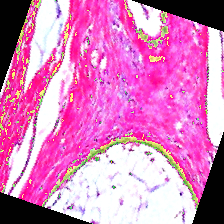

In [13]:
toPIL = transforms.ToPILImage()
toPIL(train_ds[1][0])

In [36]:
class SimpleCNN(nn.Module):
    def __init__(self):
        # ancestor constructor call
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=2)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=2)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avg = nn.AvgPool2d(8)
        self.fc = nn.Linear(512 * 1 * 1, 2) 
        
    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x)))) 
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))
        x = self.pool(F.leaky_relu(self.bn4(self.conv4(x))))
        x = self.pool(F.leaky_relu(self.bn5(self.conv5(x))))
        x = self.avg(x)
        x = x.view(-1, 512 * 1 * 1) 
        x = self.fc(x)
        return x

In [37]:
# ## Parameters for model

# # Hyper parameters
# num_epochs = 50
# num_classes = 2
# batch_size = 32
# learning_rate = 0.001

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [38]:
def train_model(dataloders, model, criterion, optimizer, scheduler=None, num_epochs=25):
    since = time.time()
    best_model_wts = model.state_dict()
    best_acc = 0.0
    dataset_sizes = {'train': len(dataloders['train'].dataset), 
                     'valid': len(dataloders['valid'].dataset)}

    for epoch in range(num_epochs):
        for phase in ['train', 'valid']:
            if phase == 'train':
#                 scheduler.step()
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloders[phase]:
                inputs, labels = inputs.to(device), labels.type(torch.LongTensor).to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
    
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels).item()
            
            if phase == 'train':
                train_epoch_loss = running_loss / dataset_sizes[phase]
                train_epoch_acc = running_corrects / dataset_sizes[phase]
            else:
                valid_epoch_loss = running_loss / dataset_sizes[phase]
                valid_epoch_acc = running_corrects / dataset_sizes[phase]
                
            if phase == 'valid' and valid_epoch_acc > best_acc:
                best_acc = valid_epoch_acc
                best_model_wts = model.state_dict()

        print('Epoch [{}/{}] train loss: {:.4f} acc: {:.4f} ' 
              'valid loss: {:.4f} acc: {:.4f}'.format(
                epoch, num_epochs - 1,
                train_epoch_loss, train_epoch_acc, 
                valid_epoch_loss, valid_epoch_acc))
            
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [47]:
model = SimpleCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate)

# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(resnet.fc.parameters(), lr=0.001, momentum=0.9)
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

dloaders = {'train':train_dl, 'valid':val_dl}

In [40]:
start_time = time.time()
model = train_model(dloaders, model, criterion, optimizer, num_epochs=50)
print('Training time: {:10f} minutes'.format((time.time()-start_time)/60))

Epoch [0/49] train loss: 0.0134 acc: 0.8083 valid loss: 0.0144 acc: 0.7750
Epoch [1/49] train loss: 0.0113 acc: 0.8472 valid loss: 0.0104 acc: 0.8625
Epoch [2/49] train loss: 0.0104 acc: 0.8514 valid loss: 0.0118 acc: 0.8063
Epoch [3/49] train loss: 0.0098 acc: 0.8674 valid loss: 0.0111 acc: 0.8313
Epoch [4/49] train loss: 0.0088 acc: 0.8729 valid loss: 0.0081 acc: 0.8750
Epoch [5/49] train loss: 0.0096 acc: 0.8660 valid loss: 0.0102 acc: 0.8562
Epoch [6/49] train loss: 0.0094 acc: 0.8701 valid loss: 0.0112 acc: 0.8187
Epoch [7/49] train loss: 0.0084 acc: 0.8771 valid loss: 0.0074 acc: 0.8938
Epoch [8/49] train loss: 0.0077 acc: 0.8993 valid loss: 0.0081 acc: 0.8562
Epoch [9/49] train loss: 0.0078 acc: 0.8938 valid loss: 0.0073 acc: 0.9062
Epoch [10/49] train loss: 0.0070 acc: 0.9132 valid loss: 0.0121 acc: 0.8750
Epoch [11/49] train loss: 0.0075 acc: 0.9021 valid loss: 0.0143 acc: 0.8125
Epoch [12/49] train loss: 0.0073 acc: 0.8986 valid loss: 0.0137 acc: 0.8688
Epoch [13/49] train lo

In [46]:
model_path = os.path.join('model','baseline.pth')
# torch.save(model.state_dict(), model_path)

In [49]:
# load model 
model.load_state_dict(torch.load(model_path))


In [41]:
# # Train the model
# total_step = len(train_dl)
# for epoch in range(num_epochs):
#     for i, (images, labels) in enumerate(train_dl):
#         images = images.to(device)
#         labels = labels.to(device)
        
#         # Forward pass
#         outputs = model(images)
#         loss = criterion(outputs, labels)
        
#         # Backward and optimize
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#         if (i+1) % 20 == 0:
#             print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
#                    .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

In [50]:
model.eval()  
y_true=[]
y_pred=[]

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in val_dl:
        images = images.to(device)
#         print(images.size())
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
#         print(predicted, labels)
        correct += (predicted == labels).sum().item()
        
        y_true+=list(labels.cpu().numpy())
        y_pred+=list(predicted.cpu().numpy())
          
    print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))


Test Accuracy of the model on the test images: 95.0 %


In [44]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)

In [51]:
cm

array([[ 49,   3],
       [  5, 103]], dtype=int64)

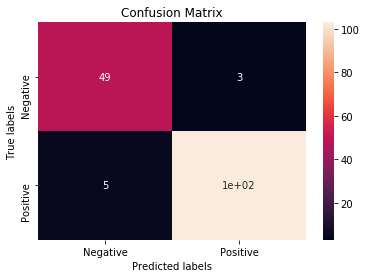

In [54]:
import seaborn as sns    

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Negative', 'Positive']); 
ax.yaxis.set_ticklabels(['Negative', 'Positive']);

In [57]:
from sklearn.metrics import f1_score, precision_score, recall_score

print(f1_score(y_true, y_pred))
print(precision_score(y_true, y_pred))
print(recall_score(y_true, y_pred))  

0.9626168224299064
0.9716981132075472
0.9537037037037037


In [58]:
# number of params
sum(p.numel() for p in model.parameters())

1571586